<a href="https://cognitiveclass.ai/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkRP0321ENSkillsNetwork25371262-2021-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0101EN-Coursera/v2/M1_R_Basics/images/IDSNlogo.png" width="200" align="center">
</a>


<h1>Refine the Baseline Regression Models</h1>

Estimated time needed: **120** minutes


## Lab Overview:

Now you have built a baseline regression model with some relatively good RMSE and R-squared reported values. However, we could still improve it by using methods like adding polynomial and interaction terms, regularization, and so on.

In this lab, you will be asked to continue using `tidymodels` to improve the performance of baseline model:

*   **TASK: Add polynomial terms**
*   **TASK: Add interactions terms**
*   **TASK: Add regularizations terms**
*   **TASK: Experiment to search for improved models**

Let's start!


First install and import necessary libraries


In [1]:
# Check whether you need to install `rlang` and `tidymodels` libraries
install.packages("rlang")
install.packages("tidymodels")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [2]:
library("tidymodels")
library("tidyverse")
library("stringr")

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip
── Attaching packages ────────────────────────────────────── tidymodels 0.1.3 ──
✔ broom        0.7.9      ✔ recipes      0.1.16
✔ dials        0.0.9      ✔ rsample      0.1.0 
✔ dplyr        1.0.7      ✔ tibble       3.1.4 
✔ ggplot2      3.3.5      ✔ tidyr        1.1.3 
✔ infer        1.0.0      ✔ tune         0.1.6 
✔ modeldata    0.1.1      ✔ workflows    0.2.3 
✔ parsnip      0.1.7      ✔ workflowsets 0.1.0 
✔ purrr        0.3.4      ✔ yardstick    0.0.8 
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ───────

The processed Seoul bike sharing dataset `seoul_bike_sharing_converted_normalized.csv`,  includes the converted indicator variables, and the numerical variables have been normalized.
Let's read it as a dataframe first:


In [3]:
# Dataset URL
dataset_url <- "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/datasets/seoul_bike_sharing_converted_normalized.csv"
bike_sharing_df <- read_csv(dataset_url)
spec(bike_sharing_df)

Parsed with column specification:
cols(
  .default = col_double(),
  DATE = col_character(),
  FUNCTIONING_DAY = col_character()
)
See spec(...) for full column specifications.


cols(
  DATE = col_character(),
  RENTED_BIKE_COUNT = col_double(),
  TEMPERATURE = col_double(),
  HUMIDITY = col_double(),
  WIND_SPEED = col_double(),
  VISIBILITY = col_double(),
  DEW_POINT_TEMPERATURE = col_double(),
  SOLAR_RADIATION = col_double(),
  RAINFALL = col_double(),
  SNOWFALL = col_double(),
  FUNCTIONING_DAY = col_character(),
  `0` = col_double(),
  `1` = col_double(),
  `10` = col_double(),
  `11` = col_double(),
  `12` = col_double(),
  `13` = col_double(),
  `14` = col_double(),
  `15` = col_double(),
  `16` = col_double(),
  `17` = col_double(),
  `18` = col_double(),
  `19` = col_double(),
  `2` = col_double(),
  `20` = col_double(),
  `21` = col_double(),
  `22` = col_double(),
  `23` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double(),
  `8` = col_double(),
  `9` = col_double(),
  AUTUMN = col_double(),
  SPRING = col_double(),
  SUMMER = col_double(),
  WINTER = col_double(),
  HOLIDAY 

We won't be using the `DATE` column, because 'as is', it basically acts like an data entry index. (However, given more time, we could use the `DATE` colum to create a 'day of week' or 'isWeekend' column, which we might expect has an affect on preferred bike rental times.) We also do not need the `FUNCTIONAL DAY` column because it only has one distinct value remaining (`YES`) after missing value processing.


In [4]:
bike_sharing_df <- bike_sharing_df %>% 
                   select(-DATE, -FUNCTIONING_DAY)

Define a linear regression model specification.


In [5]:
lm_spec <- linear_reg() %>%
  set_engine("lm") %>% 
  set_mode("regression")

Split the data into training and testing datasets.


In [6]:
set.seed(1234)
data_split <- initial_split(bike_sharing_df, prop = 4/5)
train_data <- training(data_split)
test_data <- testing(data_split)

Now we are ready to refine the previous baseline regression model.


# TASK: Add polynomial terms


Linear regression models are the most suitable models to capture the linear correlations among variables. However, in real world data, many relationships may be non-linear.


For example, the correlation between `RENTED_BIKE_COUNT` and `TEMPERATURE` does not look like linear:


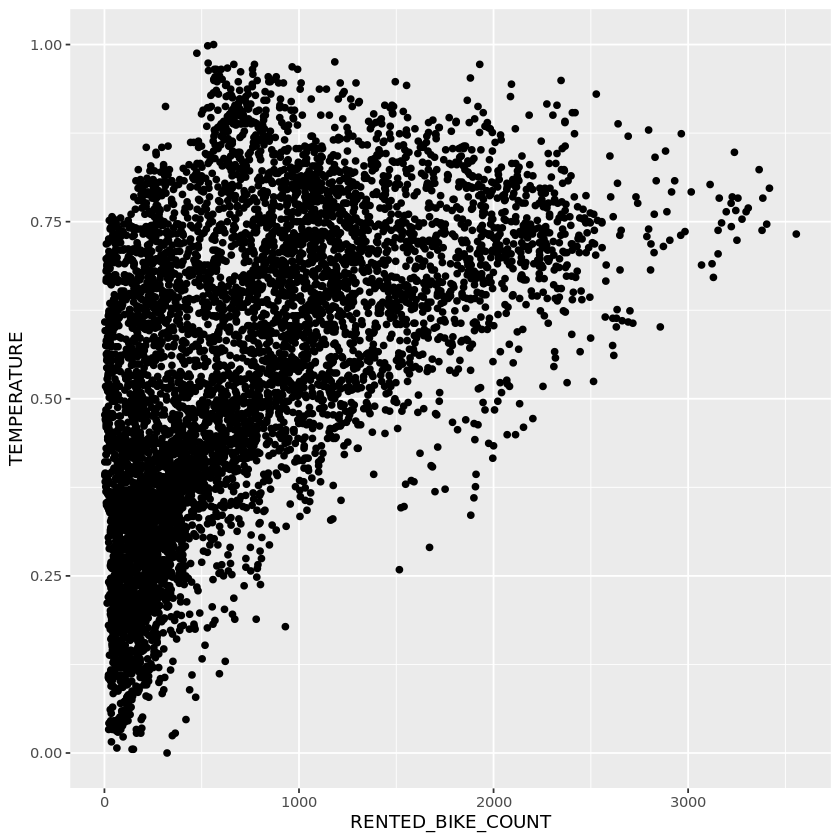

In [7]:
ggplot(data = train_data, aes(RENTED_BIKE_COUNT, TEMPERATURE)) + 
    geom_point() 

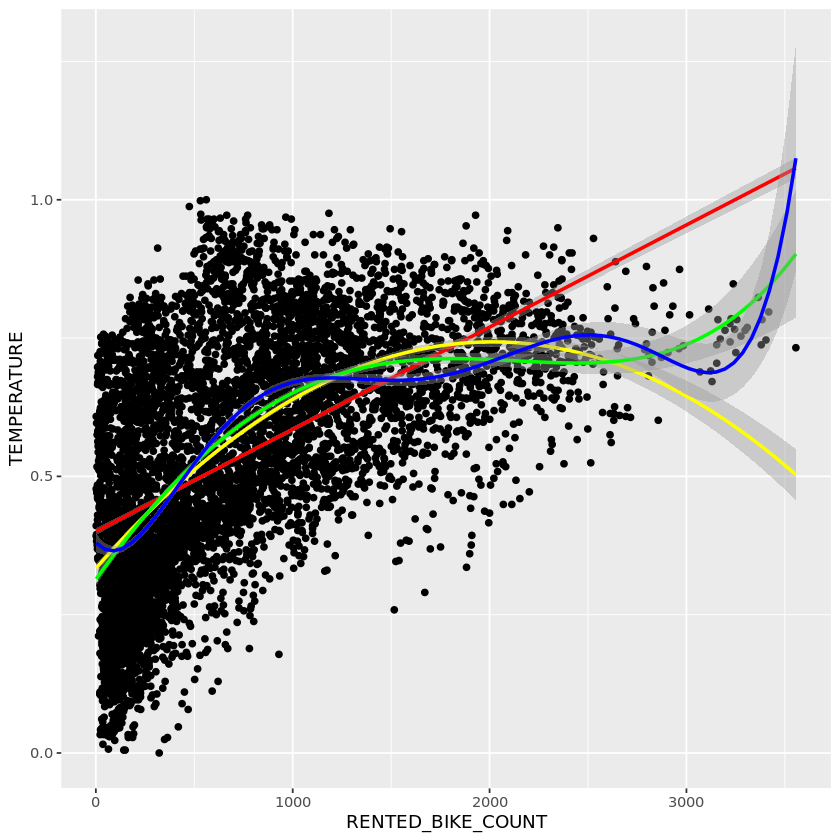

In [8]:
# Plot the higher order polynomial fits
ggplot(data=train_data, aes(RENTED_BIKE_COUNT, TEMPERATURE)) + 
    geom_point() + 
    geom_smooth(method = "lm", formula = y ~ x, color="red") + 
    geom_smooth(method = "lm", formula = y ~ poly(x, 2), color="yellow") + 
    geom_smooth(method = "lm", formula = y ~ poly(x, 4), color="green") + 
    geom_smooth(method = "lm", formula = y ~ poly(x, 6), color="blue")

OK, let's add some higher order polynomials of important variables to the regression models


*TODO:* Fit a linear regression model `lm_poly` with higher order polynomial terms on the important variables (larger coefficients) found in the baseline model


In [31]:
# Fit a linear model with higher order polynomial on some important variables 
lm_poly <-  lm_spec %>% fit(RENTED_BIKE_COUNT ~ poly(TEMPERATURE,6) + poly(RAINFALL,8) + poly(HUMIDITY,4), data = train_data)

# #HINT: Use ploy function to build polynomial terms, lm_poly <- RENTED_BIKE_COUNT ~ poly(TEMPERATURE, 6) + poly(HUMIDITY, 4) .....


In [32]:
# Print model summary

summary(lm_poly$fit)


Call:
stats::lm(formula = RENTED_BIKE_COUNT ~ poly(TEMPERATURE, 6) + 
    poly(RAINFALL, 8) + poly(HUMIDITY, 4), data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1253.42  -269.09   -64.97   197.90  2233.53 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)              734.85       5.59 131.468  < 2e-16 ***
poly(TEMPERATURE, 6)1  32462.12     470.38  69.013  < 2e-16 ***
poly(TEMPERATURE, 6)2  -6728.07     479.61 -14.028  < 2e-16 ***
poly(TEMPERATURE, 6)3  -9758.61     462.49 -21.100  < 2e-16 ***
poly(TEMPERATURE, 6)4  -2871.62     462.01  -6.215 5.42e-10 ***
poly(TEMPERATURE, 6)5   -382.68     464.31  -0.824  0.40986    
poly(TEMPERATURE, 6)6    614.87     465.69   1.320  0.18677    
poly(RAINFALL, 8)1     -3975.02     533.89  -7.445 1.09e-13 ***
poly(RAINFALL, 8)2      2905.62     498.28   5.831 5.76e-09 ***
poly(RAINFALL, 8)3     -2408.89     482.68  -4.991 6.17e-07 ***
poly(RAINFALL, 8)4      2153.71     474.50   4.539

*TODO:* Make predictions on test dataset using the `lm_poly` models


In [33]:
# Use predict() function to generate test results for `lm_poly`
test_results <- lm_poly %>%
  # Make the predictions and save the predicted values
  predict(new_data = test_data) %>%
  # Create a new column to save the true values
  mutate(truth = test_data$RENTED_BIKE_COUNT)

head(test_results)

.pred,truth
262.304148,100
259.024755,181
374.591975,360
4.945356,405
-136.845776,328
611.799147,479


Another minor improvement we could do here is to convert all negative prediction results to zero, because we can not have negative rented bike counts


In [34]:
test_results[test_results<0] <- 0
test_results

.pred,truth
262.304148,100
259.024755,181
374.591975,360
4.945356,405
0.000000,328
611.799147,479
565.015614,359
511.269884,377
352.099344,227
271.121471,32


Now, calculate R-squared and RMSE for the test results generated by `lm_ploy` model


In [35]:
# Calculate R-squared and RMSE from the test results
rsq_new <- rsq(test_results, truth = truth,
    estimate = .pred)

rmse_new <- rmse(test_results, truth = truth,
    estimate = .pred)

rsq_new
rmse_new

.metric,.estimator,.estimate
rsq,standard,0.4945814


.metric,.estimator,.estimate
rmse,standard,450.1596


If you include all variables, and additionally include some of the more important ones as higher order poly terms, then you should notice improved  `R-squared` and `RMSE` values.


# TASK: Add interaction terms


In real-world scenarios, in addition to non-linear relationships between response variables and predictor variables, you may also encounter relationships among variables called `interaction effects`.

For example, the effect of predictor variable `TEMPERATURE` on `RENTED_BIKE_COUNT` may also depend on other variables such as `HUMIDITY`, `RAINFALL`, or both (they `interact`) and the effect of `SEASON` on `RENTED_BIKE_COUNT` may also depend on `HOLIDAY`, `HOUR`, or both.

To capture such interaction effects, we could add some interaction terms such as `RAINFALL*HUMIDITY` to the regression model, similar to what we did with polynominal terms. In this task, you will explore and conduct some experiments to search for interaction terms which will improve the model performance.


*TODO:* Try adding some interaction terms to the previous polynomial models.


In [46]:
# Add interaction terms to the poly regression built in previous step
lm_poly2 <-  lm_spec %>% fit(RENTED_BIKE_COUNT ~ poly(TEMPERATURE,6) + poly(RAINFALL*HUMIDITY,8) + poly(HUMIDITY*TEMPERATURE,4), data = train_data)
# HINT: You could use `*` operator to create interaction terms such as HUMIDITY*TEMPERATURE and make the formula look like:
# RENTED_BIKE_COUNT ~ RAINFALL*HUMIDITY ...


In [47]:
# Print model summary
summary(lm_poly2$fit)


Call:
stats::lm(formula = RENTED_BIKE_COUNT ~ poly(TEMPERATURE, 6) + 
    poly(RAINFALL * HUMIDITY, 8) + poly(HUMIDITY * TEMPERATURE, 
    4), data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1339.25  -250.36   -59.69   163.22  2202.85 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         734.851      5.486 133.950  < 2e-16 ***
poly(TEMPERATURE, 6)1             44574.198    787.023  56.636  < 2e-16 ***
poly(TEMPERATURE, 6)2                10.356    605.355   0.017  0.98635    
poly(TEMPERATURE, 6)3            -14342.748    534.012 -26.858  < 2e-16 ***
poly(TEMPERATURE, 6)4             -4945.392    502.161  -9.848  < 2e-16 ***
poly(TEMPERATURE, 6)5              -622.024    457.037  -1.361  0.17356    
poly(TEMPERATURE, 6)6               336.892    457.409   0.737  0.46144    
poly(RAINFALL * HUMIDITY, 8)1     -3591.665    489.258  -7.341 2.37e-13 ***
poly(RAINFALL * HUMIDITY, 8)2      3092.

In [48]:
# Calculate R-squared and RMSE for the new model to see if performance has improved
test_results <- lm_poly2 %>%
  # Make the predictions and save the predicted values
  predict(new_data = test_data) %>%
  # Create a new column to save the true values
  mutate(truth = test_data$RENTED_BIKE_COUNT)

head(test_results)
test_results[test_results<0] <- 0
test_results
rsq_new <- rsq(test_results, truth = truth,
    estimate = .pred)

rmse_new <- rmse(test_results, truth = truth,
    estimate = .pred)

rsq_new
rmse_new

.pred,truth
160.7746,100
150.8284,181
236.5297,360
247.4778,405
220.6861,328
484.5848,479


.pred,truth
160.77462,100
150.82838,181
236.52968,360
247.47778,405
220.68612,328
484.58483,479
479.96010,359
448.82233,377
383.26109,227
350.91168,32


.metric,.estimator,.estimate
rsq,standard,0.5151564


.metric,.estimator,.estimate
rmse,standard,440.6985


# TASK: Add regularization


In previous tasks, you were asked to add polynominal and interaction terms to the model, aiming to capture nonlinearity and interaction effects between the predictor variables. Hopefully, your updated models have better R-squared and RMSE values.

However, adding these terms makes your model more complicated, more difficult to explain, and more likely to suffer from overfitting. To overcome these issues, one solution is to add regularization terms to your models.


When building the baseline model, we used the basic `lm` engine. In this task, you will use a more advanced and generalized `glmnet` engine. It provides a generalized linear model with Lasso, Ridge, and Elastic Net regularizations.

In general, using `glmnet` can enhance your models in the following ways:

*   Address overfitting issues by shrinking the coefficients
*   Address predictor variable colinearity by selecting only one variable from each group of colinear variables (by shrinking their coefficients to zero)
*   Make your models more interpretable due to simplification (fewer variables in the outcome models)


Now, let's switch our regression engine to `glmnet`


*TODO:* Define a linear regression model specification `glmnet_spec` using `glmnet` engine


In [71]:
# HINT: Use linear_reg() function with two parameters: penalty and mixture
# - penalty controls the intensity of model regularization
# - mixture controls the tradeoff between L1 and L2 regularizations
ridge_spec <- linear_reg(penalty = 0.1, mixture = 1) %>%
  set_engine("glmnet")
# You could manually try different parameter combinations or use grid search to find optimal combinations


Fit a glmnet model called  `lm_glmnet` using the `fit()` function. For the formula part, keep the polynominal and interaction terms you used in the previous task.


In [54]:
install.packages('glmnet')
library('glmnet')

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [72]:
# Fit a glmnet model using the fit() function
ridge_fit <- ridge_spec %>% 
    fit(RENTED_BIKE_COUNT ~ poly(TEMPERATURE,6) + poly(RAINFALL*HUMIDITY,8) + poly(HUMIDITY*TEMPERATURE,4), data = train_data)

test_results <- ridge_fit %>%
  # Make the predictions and save the predicted values
  predict(new_data = test_data) %>%
  # Create a new column to save the true values
  mutate(truth = test_data$RENTED_BIKE_COUNT)

test_results[test_results<0] <- 0

In [73]:
# Report rsq and rmse of the `lm_glmnet` model
rsq_new <- rsq(test_results, truth = truth,
    estimate = .pred)

rmse_new <- rmse(test_results, truth = truth,
    estimate = .pred)

rsq_new
rmse_new

.metric,.estimator,.estimate
rsq,standard,0.5150114


.metric,.estimator,.estimate
rmse,standard,440.782


# TASK: Experiment to search for improved models


Now you understand some of the methods that you can use to try to improve your models.


*TODO:* Experiment by building and testing at least five different models. For each of your experiments, include polynomial terms, interaction terms, and one of the three regularizations we introduced.


In [130]:
# Build at least five different models using polynomial terms, interaction terms, and regularizations.
ridge_spec <- linear_reg(penalty = 0.1, mixture = 1) %>%
  set_engine("glmnet") %>% 
  set_mode("regression")

ridge_fit <- ridge_spec %>% 
    fit(RENTED_BIKE_COUNT ~ poly(TEMPERATURE,6) + poly(RAINFALL*HUMIDITY,8) + poly(HUMIDITY*TEMPERATURE,6) + poly(DEW_POINT_TEMPERATURE*TEMPERATURE,6) + AUTUMN + SUMMER + SPRING + HOLIDAY + poly(SOLAR_RADIATION,2) + poly(SNOWFALL*TEMPERATURE,2), data = train_data)

test_results <- ridge_fit %>%
  # Make the predictions and save the predicted values
  predict(new_data = test_data) %>%
  # Create a new column to save the true values
  mutate(truth = test_data$RENTED_BIKE_COUNT)

test_results[test_results<0] <- 0
# Save their rmse and rsq values
rsq_new <- rsq(test_results, truth = truth,
    estimate = .pred)

rmse_new <- rmse(test_results, truth = truth,
    estimate = .pred)

rsq_new
rmse_new

.metric,.estimator,.estimate
rsq,standard,0.5670712


.metric,.estimator,.estimate
rmse,standard,416.4425


In [ ]:
# Report the best performed model in terms of rmse and rsq
ridge_spec <- linear_reg(penalty = 0.1, mixture = 1) %>%
  set_engine("glmnet") %>% 
  set_mode("regression")

ridge_fit <- ridge_spec %>% 
    fit(RENTED_BIKE_COUNT ~ poly(TEMPERATURE,6) + poly(RAINFALL*HUMIDITY,8) + poly(HUMIDITY*TEMPERATURE,6) + poly(DEW_POINT_TEMPERATURE*TEMPERATURE,6) + AUTUMN + SUMMER + SPRING + HOLIDAY + poly(SOLAR_RADIATION,2) + poly(SNOWFALL*TEMPERATURE,2), data = train_data)

Here are the performance requirements for your best model:

*   The RMSE should be less than 330 (rougly 10% of the max value in test dataset)
*   R-squared should be greater than 0.72


*TODO:* Visualize the saved RMSE and R-squared values using a grouped barchart


In [ ]:
# HINT: Use ggplot() + geom_bar()


*TODO:* Create a Q-Q plot by plotting the distribution difference between the predictions generated by your best model and the true values on the test dataset.


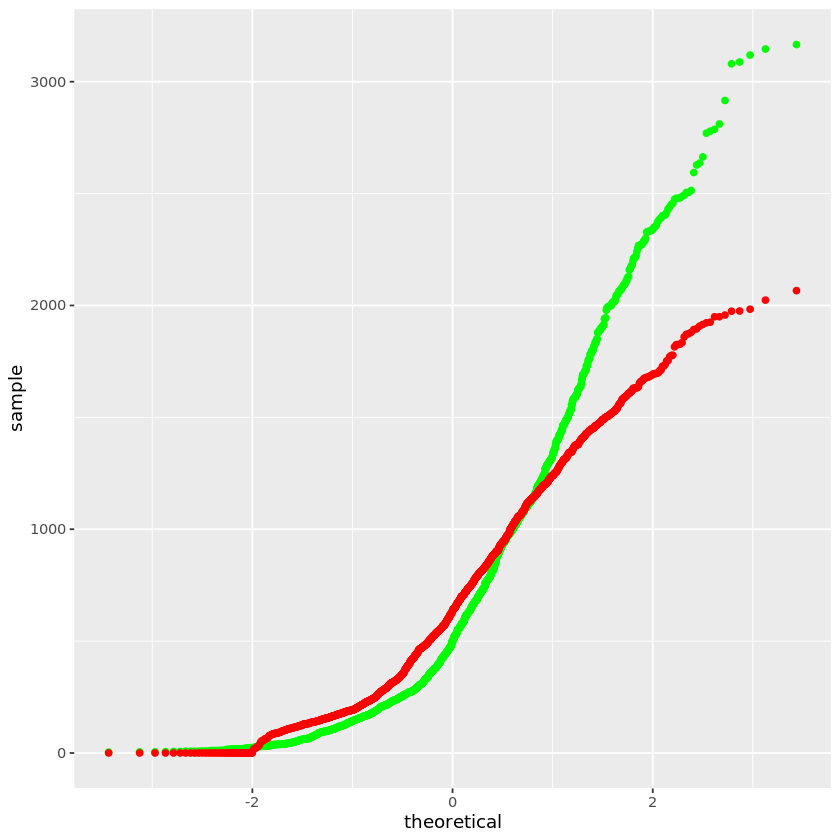

In [131]:
# HINT: Use ggplot() +
    # stat_qq(aes(sample=truth), color='green') +
    # stat_qq(aes(sample=prediction), color='red')
library(ggplot2)
ggplot(test_results) +
stat_qq(aes(sample=truth), color='green') +
stat_qq(aes(sample=.pred), color='red')

One example of such Q-Q plot may look like this:


<a href="https://cognitiveclass.ai/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkRP0321ENSkillsNetwork25371262-2021-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/module_4/images/example_qq_plot.png" width="600" align="center">
</a>


# More model improvment methods beyond this course


In addition to the methods mentioned in this lab and previous data analysis courses, you could also explore to try the following methods yourself to see if they could improve model performance:

*   Remove potential redundant variables. If two variables have extremly high correlated, it is possible that they are redundant and could be removed from the model to improve the performance.
*   Remove some outliers. Linear regression models are very sensitive to outliers, you could try to remove some outliers to see if it would improve performance
*   Apply logarithm transformation. In case variable distributions are not normal distribution such as log-normal distribution, you could apply logaritm transformation on the variable to make them more look like normal distribution. In addition, logarithm transformation helps capture the non-linear relationships.

If you have time, you could research and try more methods by searching related research papers/articles, discussion forums, etc. If you know how to use other machine learning models with `Tidymodels` such as Neural Networks, Tree models, or Boosting models, you can also try and compare them with the linear regression models.


# Next Steps:


Great! You have improved your baseline model using polynomial terms, interaction terms, and regularizations, and have found your best model.

Now it's time to build an interactive dashboard to provide more interactive user-interactions.


## Authors

<a href="https://www.linkedin.com/in/yan-luo-96288783/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkRP0321ENSkillsNetwork25371262-2021-01-01" target="_blank">Yan Luo</a>


### Other Contributors

Jeff Grossman


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description      |
| ----------------- | ------- | ---------- | ----------------------- |
| 2021-04-08        | 1.0     | Yan        | Initial version created |
|                   |         |            |                         |
|                   |         |            |                         |

## <h3 align="center"> © IBM Corporation 2021. All rights reserved. <h3/>
